In [ ]:
!pip install gymnasium[mujoco]

In [ ]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt
from typing_extensions import dataclass_transform

In [ ]:
# Hyperparameters
data = {
    "env_n": "InvertedPendulum-v4",
    "L_R": 1e-3,
    "gamma": 0.99,
    "buffer_s": 10000,
    "batch_s": 64,
    "ep_start": 1.0,
    "ep_end": 0.01,
    "ep_decay": 0.995,
    "target_up_freq": 10,
    "num_eps": 500,
}

In [ ]:
class DiscreteActionWrapper(gym.ActionWrapper):
    def __init__(self, env):
        super().__init__(env)

        self.action_space = gym.spaces.Discrete(2)
        self._action_map = {
            0: np.array([-3.0], dtype=np.float32), # Push left
            1: np.array([3.0], dtype=np.float32),  # Push right
        }

    def action(self, action):
        return self._action_map[action]

In [ ]:
# Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def store(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

In [ ]:
#creating Q-Network Architecture
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, x):
        return self.network(x)

In [ ]:
# creating DQN Agent
class DQNAgent:
    def __init__(self, s_dim, a_dim, config):
        self.state_dim = s_dim
        self.action_dim = a_dim
        self.config = config
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.q_nw = QNetwork(s_dim, a_dim).to(self.device)
        self.target_nw = QNetwork(s_dim, a_dim).to(self.device)
        self.target_nw.load_state_dict(self.q_nw.state_dict())
        self.target_nw.eval()

        self.opt = optim.Adam(self.q_nw.parameters(), lr=self.config["L_R"])
        self.replay_buffer = ReplayBuffer(self.config["buffer_s"])
        self.epsilon = self.config["ep_start"]

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.action_dim - 1) # Explore
        else:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
                q_values = self.q_nw(state_tensor)
                return torch.argmax(q_values).item() # Exploit

    def learn(self):
        if len(self.replay_buffer) < self.config["batch_s"]:
            return

        batch = self.replay_buffer.sample(self.config["batch_s"])
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(np.array(states)).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(np.array(next_states)).to(self.device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(self.device)

        # Getting current Q-values from the main network
        current_q_values = self.q_nw(states).gather(1, actions)

        # Getting next Q-values from the target network
        with torch.no_grad():
            next_q_val_max = self.target_nw(next_states).max(1)[0].unsqueeze(1)

            target_q_val = rewards + (1 - dones) * self.config["gamma"] * next_q_val_max

        # Compute MSE (loss)
        loss = nn.MSELoss()(current_q_values, target_q_val)

        # Optimizing the model
        self.opt.zero_grad()
        loss.backward()
        self.opt.step()

    def update_epsilon(self):
        self.epsilon = max(self.config["ep_end"], self.epsilon * self.config["ep_decay"])

    def update_target_network(self):
        self.target_nw.load_state_dict(self.q_nw.state_dict())

In [ ]:
def train():

    base_env = gym.make(data["env_n"])
    env = DiscreteActionWrapper(base_env)

    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    agent = DQNAgent(state_dim, action_dim, data)

    print(f"State space dimension: {state_dim}")
    print(f"Action space dimension: {action_dim}")

    episode_rewards = []


    for eps in range(data["num_eps"]):
        state, _ = env.reset()
        eps_reward = 0
        terminated = False
        truncated = False

        while not terminated and not truncated:
            action = agent.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)\

            agent.replay_buffer.store(state, action, reward, next_state, terminated or truncated)

            agent.learn()

            state = next_state
            eps_reward += reward


        agent.update_epsilon()
        if eps % data["target_up_freq"] == 0:
            agent.update_target_network()

        episode_rewards.append(eps_reward)
        print(f"Episode {eps + 1}/{data['num_eps']}, Reward: {eps_reward:.2f}, Epsilon: {agent.epsilon:.3f}")

    print("Training Finished")
    env.close()
    return agent, episode_rewards

In [ ]:
def performance(agent, episode_rewards):
    # Plotting the rewards
    plt.figure(figsize=(12, 6))
    plt.plot(episode_rewards, label='Reward per Episode')

    moving_avg = np.convolve(episode_rewards, np.ones(50)/50, mode='valid')
    plt.plot(np.arange(len(moving_avg)) + 49, moving_avg, label='50-episode Moving Average', color='red', linewidth=2)
    plt.title('DQN Training Performance on InvertedPendulum-v4')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.legend()
    plt.grid(True)
    plt.savefig('dqn_performance_plot.png')
    plt.show()

    print("\n Demonstrating Trained Agent")

    render_env = gym.make(data["env_n"], render_mode='human')
    render_env = DiscreteActionWrapper(render_env)

    for i in range(3):
        state, _ = render_env.reset()
        done = False
        t_reward = 0
        print(f"Demonstration Episode {i+1}")
        while not done:
            render_env.render()
            with torch.no_grad():

                s_tensor = torch.FloatTensor(state).unsqueeze(0).to(agent.device)
                q_val = agent.q_nw(s_tensor)
                action = torch.argmax(q_val).item()

            next_s, reward, terminated, truncated, _ = render_env.step(action)
            state = next_s
            t_reward += reward
            done = terminated or truncated
        print(f"Total reward for demonstration episode: {t_reward:.2f}\n")

    render_env.close()

/usr/local/lib/python3.12/dist-packages/gymnasium/envs/registration.py:512: DeprecationWarning: WARN: The environment InvertedPendulum-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


Using device: cpu
State space dimension: 4
Action space dimension: 2
Episode 1/500, Reward: 8.00, Epsilon: 0.995
Episode 2/500, Reward: 3.00, Epsilon: 0.990
Episode 3/500, Reward: 3.00, Epsilon: 0.985
Episode 4/500, Reward: 7.00, Epsilon: 0.980
Episode 5/500, Reward: 3.00, Epsilon: 0.975
Episode 6/500, Reward: 7.00, Epsilon: 0.970
Episode 7/500, Reward: 5.00, Epsilon: 0.966
Episode 8/500, Reward: 4.00, Epsilon: 0.961
Episode 9/500, Reward: 5.00, Epsilon: 0.956
Episode 10/500, Reward: 3.00, Epsilon: 0.951
Episode 11/500, Reward: 3.00, Epsilon: 0.946
Episode 12/500, Reward: 3.00, Epsilon: 0.942
Episode 13/500, Reward: 3.00, Epsilon: 0.937
Episode 14/500, Reward: 7.00, Epsilon: 0.932
Episode 15/500, Reward: 3.00, Epsilon: 0.928
Episode 16/500, Reward: 3.00, Epsilon: 0.923
Episode 17/500, Reward: 3.00, Epsilon: 0.918
Episode 18/500, Reward: 7.00, Epsilon: 0.914
Episode 19/500, Reward: 3.00, Epsilon: 0.909
Episode 20/500, Reward: 4.00, Epsilon: 0.905
Episode 21/500, Reward: 4.00, Epsilon: 0

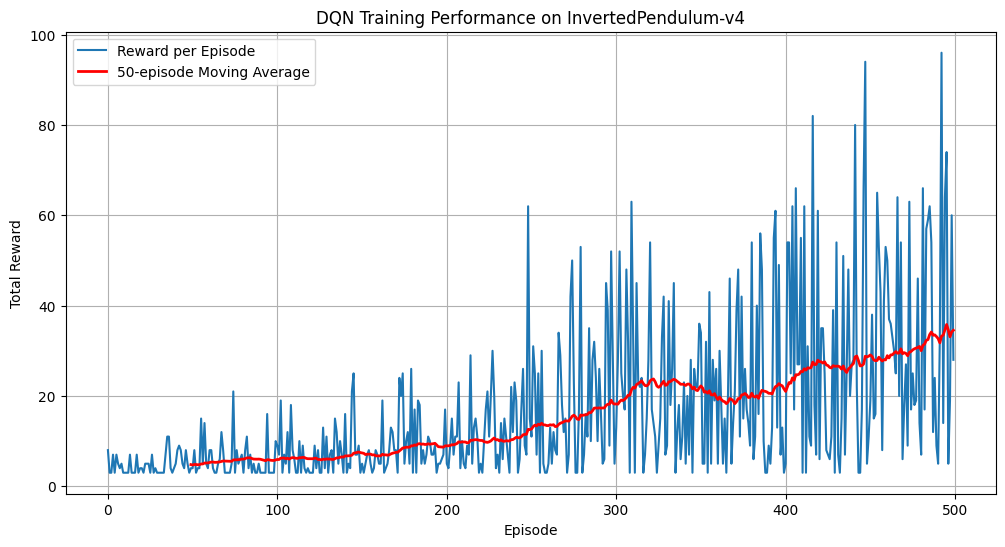

In [ ]:
trained_agent, rewards = train()
performance(trained_agent, rewards)

Using device: cpu
 Starting Training 
State space dimension: 4
Action space dimension: 2
Episode 1/500, Reward: 3.00, Epsilon: 0.995
Episode 2/500, Reward: 3.00, Epsilon: 0.990
Episode 3/500, Reward: 3.00, Epsilon: 0.985
Episode 4/500, Reward: 3.00, Epsilon: 0.980
Episode 5/500, Reward: 3.00, Epsilon: 0.975
Episode 6/500, Reward: 7.00, Epsilon: 0.970
Episode 7/500, Reward: 3.00, Epsilon: 0.966
Episode 8/500, Reward: 5.00, Epsilon: 0.961
Episode 9/500, Reward: 5.00, Epsilon: 0.956
Episode 10/500, Reward: 4.00, Epsilon: 0.951
Episode 11/500, Reward: 3.00, Epsilon: 0.946
Episode 12/500, Reward: 3.00, Epsilon: 0.942
Episode 13/500, Reward: 4.00, Epsilon: 0.937
Episode 14/500, Reward: 3.00, Epsilon: 0.932
Episode 15/500, Reward: 3.00, Epsilon: 0.928
Episode 16/500, Reward: 5.00, Epsilon: 0.923
Episode 17/500, Reward: 3.00, Epsilon: 0.918
Episode 18/500, Reward: 3.00, Epsilon: 0.914
Episode 19/500, Reward: 4.00, Epsilon: 0.909
Episode 20/500, Reward: 4.00, Epsilon: 0.905
Episode 21/500, Rewa

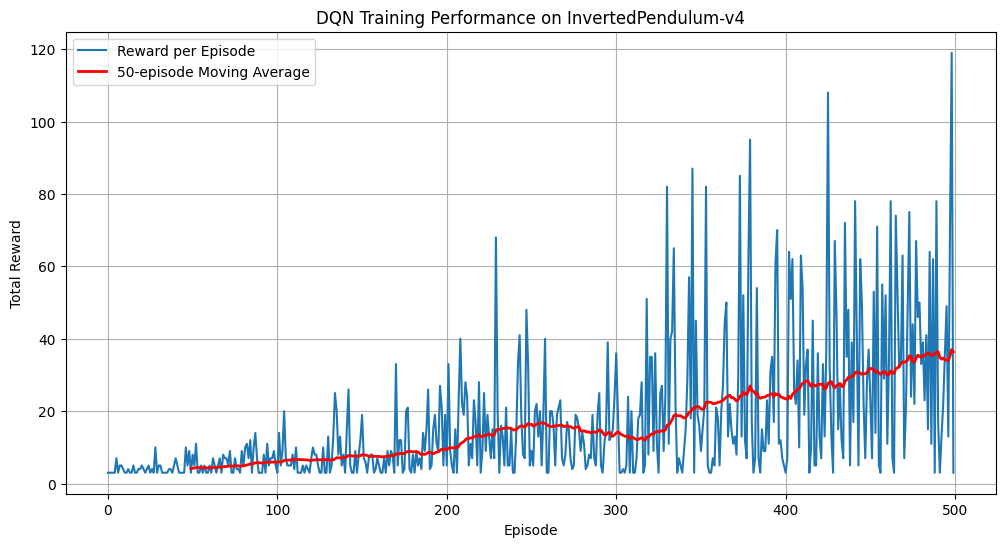

In [ ]:
from typing_extensions import dataclass_transform
# Hyperparameters
data = {
    "env_n": "InvertedPendulum-v4",
    "L_R": 1e-3,
    "gamma": 0.99,
    "buffer_s": 10000,
    "batch_s": 64,
    "ep_start": 1.0,
    "ep_end": 0.01,
    "ep_decay": 0.995,
    "target_up_freq": 10,
    "num_eps": 500,
}

class DiscreteActionWrapper(gym.ActionWrapper):
    def __init__(self, env):
        super().__init__(env)

        self.action_space = gym.spaces.Discrete(2)
        self._action_map = {
            0: np.array([-3.0], dtype=np.float32), # Push left
            1: np.array([3.0], dtype=np.float32),  # Push right
        }

    def action(self, action):
        return self._action_map[action]

#Train a Controller using DQN

# Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def store(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

#Q-Network Architecture
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, x):
        return self.network(x)

# DQN Agent
class DQNAgent:
    def __init__(self, state_dim, action_dim, config):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.config = config
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

        # Create main and target networks
        self.q_nw = QNetwork(state_dim, action_dim).to(self.device)
        self.target_nw = QNetwork(state_dim, action_dim).to(self.device)
        self.target_nw.load_state_dict(self.q_nw.state_dict())
        self.target_nw.eval() # Target network is only for inference

        self.opt = optim.Adam(self.q_nw.parameters(), lr=self.config["L_R"])
        self.replay_buffer = ReplayBuffer(self.config["buffer_s"])
        self.epsilon = self.config["ep_start"]

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.action_dim - 1) # Explore
        else:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
                q_values = self.q_nw(state_tensor)
                return torch.argmax(q_values).item() # Exploit

    def learn(self):
        if len(self.replay_buffer) < self.config["batch_s"]:
            return

        batch = self.replay_buffer.sample(self.config["batch_s"])
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(np.array(states)).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(np.array(next_states)).to(self.device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(self.device)

        # Get current Q-values from the main network
        current_q_values = self.q_nw(states).gather(1, actions)

        # Get next Q-values from the target network
        with torch.no_grad():
            next_q_val_max = self.target_nw(next_states).max(1)[0].unsqueeze(1)
            # Compute the target Q-value
            target_q_val = rewards + (1 - dones) * self.config["gamma"] * next_q_val_max

        # Compute loss (Mean Squared Error)
        loss = nn.MSELoss()(current_q_values, target_q_val)

        # Optimize the model
        self.opt.zero_grad()
        loss.backward()
        self.opt.step()

    def update_epsilon(self):
        """Decay epsilon."""
        self.epsilon = max(self.config["ep_end"], self.epsilon * self.config["ep_decay"])

    def update_target_network(self):
        """Copy weights from the main network to the target network."""
        self.target_nw.load_state_dict(self.q_nw.state_dict())


# Main Training Loop
def train():
    # Initialize environment and agent
    base_env = gym.make(data["env_n"])
    env = DiscreteActionWrapper(base_env)

    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    agent = DQNAgent(state_dim, action_dim, data)

    print(" Starting Training ")
    print(f"State space dimension: {state_dim}")
    print(f"Action space dimension: {action_dim}")

    episode_rewards = []

    # 2. Loop for a number of episodes
    for episode in range(data["num_eps"]):
        state, _ = env.reset()
        episode_reward = 0
        terminated = False
        truncated = False

        # 3. Loop through steps in an episode
        while not terminated and not truncated:
            action = agent.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)

            # Store experience in replay buffer
            agent.replay_buffer.store(state, action, reward, next_state, terminated or truncated)

            # Perform a learning step
            agent.learn()

            state = next_state
            episode_reward += reward

        # Post-episode updates
        agent.update_epsilon()
        if episode % data["target_up_freq"] == 0:
            agent.update_target_network()

        episode_rewards.append(episode_reward)
        print(f"Episode {episode + 1}/{data['num_eps']}, Reward: {episode_reward:.2f}, Epsilon: {agent.epsilon:.3f}")

    print("Training Finished")
    env.close()
    return agent, episode_rewards

# Demonstrate Performance
def demonstrate_performance(agent, episode_rewards):
    # A. Plotting the rewards
    plt.figure(figsize=(12, 6))
    plt.plot(episode_rewards, label='Reward per Episode')

    moving_avg = np.convolve(episode_rewards, np.ones(50)/50, mode='valid')
    plt.plot(np.arange(len(moving_avg)) + 49, moving_avg, label='50-episode Moving Average', color='red', linewidth=2)
    plt.title('DQN Training Performance on InvertedPendulum-v4')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.legend()
    plt.grid(True)
    plt.savefig('dqn_performance_plot.png')
    plt.show()

    # B. Rendering the trained agent's performance
    print("\n--- Demonstrating Trained Agent ---")

    # Use a special environment for rendering
    render_env = gym.make(data["env_n"], render_mode='human')
    render_env = DiscreteActionWrapper(render_env)

    for i in range(3): # Run 3 demonstration episodes
        state, _ = render_env.reset()
        done = False
        t_reward = 0
        print(f"Demonstration Episode {i+1}")
        while not done:
            render_env.render()
            with torch.no_grad():
                # Always choose the best action (no exploration)
                s_tensor = torch.FloatTensor(state).unsqueeze(0).to(agent.device)
                q_val = agent.q_nw(s_tensor)
                action = torch.argmax(q_val).item()

            next_s, reward, terminated, truncated, _ = render_env.step(action)
            state = next_s
            t_reward += reward
            done = terminated or truncated
        print(f"Total reward for demonstration episode: {t_reward:.2f}\n")

    render_env.close()


if __name__ == "__main__":
    trained_agent, rewards = train()
    demonstrate_performance(trained_agent, rewards)